In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# read in the data
df = pd.read_csv("./../data/supervised_1_1.csv")

In [3]:
print(df.shape)
df.set_index('date', inplace=True)
df.head()

(7115050, 20)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,rotterdam,brent,wti,eurusd,vehicles,state,station,num_days
date,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622837,109.424042,101.258553,1.369886,15211.0,10,0,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622486,109.699997,101.669998,1.369580,9146.0,10,0,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622136,109.699997,101.669998,1.369580,9843.0,10,0,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.621785,109.838928,102.008537,1.370161,13502.0,10,0,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.620475,109.522926,102.058907,1.368282,12876.0,10,0,4


In [4]:
# try removing the averages so as to not include endogenous variables on the rigth hand side
df.drop(['eurusd', 'vehicles'], axis=1, inplace=True)
print(df.shape)
df.head()

(7115050, 17)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,rotterdam,brent,wti,state,station,num_days
date,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622837,109.424042,101.258553,10,0,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622486,109.699997,101.669998,10,0,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622136,109.699997,101.669998,10,0,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.621785,109.838928,102.008537,10,0,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.620475,109.522926,102.058907,10,0,4


In [5]:
# replace the oil prices for the last 30 days with the predictions
oil = pd.read_csv('./../data/linear_oil_yhat.csv')

last_30 = ['2015-11-11', '2015-11-13', '2015-11-14', '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
          '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22', '2015-11-23', '2015-11-24', '2015-11-25',
          '2015-11-26', '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30', '2015-12-01', '2015-12-02',
          '2015-12-03', '2015-12-04', '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09',
          '2015-12-10', '2015-12-10']

for index, date in enumerate(last_30):
    df.loc[date, 'rotterdam'] = oil['rot_yhat'][index]
    df.loc[date, 'brent'] = oil['brent_yhat'][index]
    df.loc[date, 'wti'] = oil['wti_yhat'][index]

In [6]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = pd.DataFrame(scaler.fit_transform(values))
# frame as supervised learning
n_seq = 1
reframed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.398580,0.833333,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.837361,0.930292,0.921895,0.384615,0.0,0.000000
1,0.415691,1.000000,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.836386,0.933953,0.927822,0.384615,0.0,0.001742
2,0.419080,0.000000,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.835411,0.933953,0.927822,0.384615,0.0,0.003484
3,0.424554,0.166667,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.834437,0.935795,0.932700,0.384615,0.0,0.005226
4,0.437586,0.333333,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.830794,0.931604,0.933425,0.384615,0.0,0.006969


In [7]:
# split into train and test sets
# now order needs to be by day rather than by station -- reorder by num_days
# num_days is 16 and 15 is station
reframed.sort_values(by=[16, 15], inplace=True)
day_30 = reframed[16].unique()[-30]
train = reframed.loc[reframed[16] < day_30]
test = reframed.loc[reframed[16] >= day_30]

In [8]:
n_seq = 1
train_values = train.values
test_values = test.values
# split into input and outputs
train_X, train_y = train_values[:, n_seq:], train_values[:, :n_seq]
test_X, test_y = test_values[:, n_seq:], test_values[:, :n_seq]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6743830, 1, 16) (6743830, 1) (371220, 1, 16) (371220, 1)


Train on 6743830 samples, validate on 371220 samples
Epoch 1/10
 - 39s - loss: 0.0215 - val_loss: 0.0164
Epoch 2/10
 - 37s - loss: 0.0155 - val_loss: 0.0165
Epoch 3/10
 - 44s - loss: 0.0150 - val_loss: 0.0156
Epoch 4/10
 - 45s - loss: 0.0149 - val_loss: 0.0150
Epoch 5/10
 - 44s - loss: 0.0147 - val_loss: 0.0149
Epoch 6/10
 - 55s - loss: 0.0146 - val_loss: 0.0150
Epoch 7/10
 - 47s - loss: 0.0144 - val_loss: 0.0151
Epoch 8/10
 - 44s - loss: 0.0143 - val_loss: 0.0152
Epoch 9/10
 - 45s - loss: 0.0142 - val_loss: 0.0153
Epoch 10/10
 - 40s - loss: 0.0141 - val_loss: 0.0154


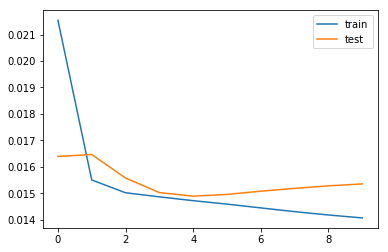

In [9]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_seq))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=7200, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [10]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 0:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.032
